# Project Notebook

Kelvin Gilian Mulder - 12253286, Nitai Nijholt - 12709018, Kevin Veenboer - 12604275

In [178]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.inspection import permutation_importance

## RIVM

In [2]:
#delimter is ;
DirList = os.listdir(r'C:\Users\Kevin\Desktop\Per_2_Minor\ML\Project\Project\RIVM\Set_Type_2')
path = 'C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/RIVM/Set_Type_2/' + DirList[0]
#DirList = os.listdir('C:\\Users\\Nitai Nijholt\\Downloads\\ML UvA course\\Machine Learning\\maschine learning project\\Kevins Data\\')
#path = 'C:\\Users\\Nitai Nijholt\\Downloads\\ML UvA course\\Machine Learning\\maschine learning project\\Kevins Data\\' + DirList[0]
df_RIVM = pd.read_csv(path, sep=';')
df_RIVM = df_RIVM.rename(columns={'Codering_3':'gwb_code'})
df_RIVM = df_RIVM.astype({'gwb_code': 'string'})
df_RIVM.gwb_code = df_RIVM.gwb_code.str.strip()
df_RIVM = df_RIVM.drop(columns = ['LopenEnOfFietsenNaarSchoolOfWerk_34', 'LopenNaarSchoolOfWerk_35','FietsenNaarSchoolOfWerk_36'])

filtered =  ['ID', 'Leeftijd', 'Marges', 'WijkenEnBuurten', 'Perioden','Gemeentenaam_1', 'SoortRegio_2', 'gwb_code']
for col in df_RIVM.columns:
    #print(col)
    if col in filtered:
        continue
    df_RIVM[col] = df_RIVM[col].str.strip()
    df_RIVM[col] = pd.to_numeric(df_RIVM[col], errors = 'coerce', downcast = 'float')

## CBS

In [3]:
DirList = os.listdir('C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/CBS set')
path = 'C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/CBS set/' + DirList[1]
#DirList = os.listdir('C:\\Users\\Nitai Nijholt\\Downloads\\ML UvA course\\Machine Learning\\maschine learning project\\Kevins Data\\')
#path = 'C:\\Users\\Nitai Nijholt\\Downloads\\ML UvA course\\Machine Learning\\maschine learning project\\Kevins Data\\' + DirList[1]
df_CBS = pd.read_excel(path)
df_CBS = df_CBS.astype({'gwb_code': 'string'})

filtered = ['gwb_code_10', 'gwb_code_8', 'regio', 'gm_naam', 'recs', 'gwb_code']
categorical = ['pst_mvp', 'pst_dekp']
for col in df_CBS.columns:
    
    if col in filtered or col in categorical:
        continue
    if not (df_CBS[col].dtype == 'int64' or df_CBS[col].dtype == 'float64'):
        df_CBS[col] = df_CBS[col].str.strip()
    df_CBS[col] = pd.to_numeric(df_CBS[col], errors = 'coerce')
    
df_CBS = df_CBS.drop(columns = ['pst_mvp','pst_dekp']) #Postcode data kan waarschijnlijk wel weg
#pd.get_dummies(df_CBS, columns = ['ste_mvs']) #heeft een orde er inzitten (inverse van stedlijkheid) miscchien maar zo laten

## merging

In [4]:
Labels = df_RIVM[['ID','gwb_code','Gemeentenaam_1', 'SoortRegio_2']]
Sub_RIVM = df_RIVM.drop(columns = ['Leeftijd', 'Marges', 'WijkenEnBuurten', 'Perioden','Gemeentenaam_1', 'SoortRegio_2'])
Sub_CBS = df_CBS.drop(columns = ['gwb_code_10', 'gwb_code_8', 'regio', 'gm_naam', 'recs'])

In [5]:
df_COM = pd.merge(Sub_CBS, Sub_RIVM, on = "gwb_code", how="inner")
df_COM = df_COM.drop(columns = ['gwb_code']) # zou met labels dataframe later weer moeten kunnen linken op ID maar heb dat nog niet gecheckt

## cleaning after merge

### Checking

In [6]:
df_COM.describe()

,ind_wbi,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,...,HeelVeelStressInAfgelopen4Weken_26,MatigVeelRegieOverEigenLeven_27,Eenzaam_28,ErnstigZeerErnstigEenzaam_29,EmotioneelEenzaam_30,SociaalEenzaam_31,Mantelzorger_32,Vrijwilligerswerk_33,ErnstigeGeluidhinderDoorBuren_37,MoeiteMetRondkomen_38
count,16627.000000,1.698300e+04,1.698300e+04,1.698300e+04,1.698300e+04,1.698300e+04,1.698300e+04,1.698300e+04,1.698300e+04,1.698300e+04,...,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000
mean,1.097612,4.099076e+03,2.036049e+03,2.062386e+03,6.420637e+02,5.048635e+02,1.014764e+03,1.139034e+03,7.990158e+02,1.995471e+03,...,15.775554,91.083664,44.058922,9.588150,25.566902,28.276207,14.440805,28.166983,5.538527,11.314319
std,0.423547,1.341944e+05,6.666591e+04,6.752856e+04,2.101511e+04,1.653697e+04,3.330076e+04,3.725742e+04,2.611534e+04,6.544336e+04,...,4.091187,2.669610,6.373522,3.401879,6.423074,4.517572,2.531733,6.920620,2.438867,5.638656
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.000000,72.000000,22.299999,2.600000,9.600000,15.100000,2.400000,9.200000,0.900000,1.400000
25%,1.000000,2.600000e+02,1.350000e+02,1.250000e+02,3.500000e+01,3.000000e+01,4.500000e+01,8.000000e+01,4.500000e+01,1.100000e+02,...,12.800000,89.800003,39.400002,7.100000,20.900000,25.100000,13.100000,22.900000,3.600000,7.500000
50%,1.000000,9.700000e+02,4.850000e+02,4.850000e+02,1.400000e+02,1.100000e+02,2.100000e+02,2.750000e+02,1.800000e+02,4.400000e+02,...,14.900000,91.599998,42.700001,8.800000,24.100000,27.299999,14.700000,28.100000,5.200000,9.800000
75%,1.000000,2.450000e+03,1.215000e+03,1.225000e+03,3.800000e+02,2.900000e+02,5.950000e+02,6.850000e+02,4.800000e+02,1.180000e+03,...,17.900000,92.900002,47.700001,11.300000,29.000000,30.700001,16.100000,33.299999,7.100000,13.600000
max,3.000000,1.740758e+07,8.648031e+06,8.759554e+06,2.726099e+06,2.143743e+06,4.308904e+06,4.836284e+06,3.392555e+06,8.474556e+06,...,39.200001,97.300003,79.500000,32.299999,64.699997,53.700001,26.700001,57.500000,14.900000,44.000000


In [7]:
#Some data was not present acording to the CBS so these can be dropped
Empty = []
for col in df_COM.columns:
    val = df_COM[col].isna().sum()
    if val > 16982: Empty.append(col)
df_COM = df_COM.drop(columns = Empty) 

In [8]:
#Checking if some collumns still have NAs to resolve
NA = {}
for col in df_COM.columns:
    val = df_COM[col].isna().sum()
    if val > 0: NA[col] = val
        
print(f'Amount of columns with missing values: {len(NA)}')

Amount of columns with missing values: 60


In [9]:
#printing columns with NAs from low to high
for i in sorted(NA, key=NA.get):
    print(f"NAME:{i}, NAs:{NA[i]}")

NAME:ste_mvs, NAs:1
NAME:ste_oad, NAs:1
NAME:bev_dich, NAs:345
NAME:ind_wbi, NAs:356
NAME:ErvarenGezondheidGoedZeerGoed_4, NAs:411
NAME:VoldoetAanBeweegrichtlijn_5, NAs:411
NAME:WekelijkseSporters_6, NAs:411
NAME:Ondergewicht_7, NAs:411
NAME:NormaalGewicht_8, NAs:411
NAME:Overgewicht_9, NAs:411
NAME:ErnstigOvergewicht_10, NAs:411
NAME:Roker_11, NAs:411
NAME:VoldoetAanAlcoholRichtlijn_12, NAs:411
NAME:Drinker_13, NAs:411
NAME:ZwareDrinker_14, NAs:411
NAME:OvermatigeDrinker_15, NAs:411
NAME:EenOfMeerLangdurigeAandoeningen_16, NAs:411
NAME:BeperktVanwegeGezondheid_17, NAs:411
NAME:ErnstigBeperktVanwegeGezondheid_18, NAs:411
NAME:LangdurigeZiekteEnBeperkt_19, NAs:411
NAME:EenOfMeerLichamelijkeBeperkingen_20, NAs:411
NAME:BeperkingInHoren_21, NAs:411
NAME:BeperkingInZien_22, NAs:411
NAME:BeperkingInBewegen_23, NAs:411
NAME:MatigHoogRisicoOpAngstOfDepressie_24, NAs:411
NAME:HoogRisicoOpAngstOfDepressie_25, NAs:411
NAME:HeelVeelStressInAfgelopen4Weken_26, NAs:411
NAME:MatigVeelRegieOverEigenL

In [10]:
#g_pau_km is vertekenend volgens CBS uitleg
#a_bed_a, a_bed_gi, a_bed_hj, a_bed_kl, a_bed_mn zijn voorlopig en er ontbreekt wel heel veel, het is specifieke berijf data

### Excessives

In [11]:
#The columns with more than 2000 NaNs have been determined to be uninformative based on the variable explanantions of the CBS

Excessive = []
for col in df_COM.columns:
    val = df_COM[col].isna().sum()
    if val > 2000: Excessive.append(col)
print(Excessive)
df_COM = df_COM.drop(columns = Excessive) 

['a_bed_a', 'a_bed_bf', 'a_bed_gi', 'a_bed_hj', 'a_bed_kl', 'a_bed_mn', 'a_bed_ru', 'g_pau_km']


### Problematic

In [12]:
Problematic = []
for col in df_COM.columns:
    val = df_COM[col].isna().sum()
    if val > 1000: Problematic.append(col)

print(Problematic)

['g_woz', 'p_1gezw', 'p_mgezw', 'p_bewndw', 'p_leegsw', 'p_koopw', 'p_huurw', 'p_wcorpw', 'p_ov_hw', 'p_e_o_w', 'p_bjj2k', 'p_bjo2k', 'a_soz_wb', 'a_soz_ao', 'a_soz_ww', 'a_soz_ow']


In [13]:
'''
Here I check the ammount of NaN per row to see wheter some rows are just completly NaN if so median is probably best to use
Will check the amount of rows with NaN and the rows with most NaN, basically check the NaN distribution
'''

NA_rows = {}
for Idx,Data in df_COM.iterrows():
    val = Data.isna().sum()
    if val > 0: NA_rows[Idx] = val



In [14]:
#Total rows with NaN
print(f"ammount of rows with 1 or more NaN: {len(NA_rows)}")

ammount of rows with 1 or more NaN: 2075


In [15]:
#Printing rows with NaNs from little to many
inspect = []
clear = []
for i in sorted(NA_rows, key=NA_rows.get):
    if NA_rows[i] > 17: inspect.append(i)
    else: clear.append(i)
    print(f"NAME:{i}, NAs:{NA_rows[i]}")

NAME:0, NAs:1
NAME:1, NAs:1
NAME:9, NAs:1
NAME:52, NAs:1
NAME:66, NAs:1
NAME:100, NAs:1
NAME:187, NAs:1
NAME:227, NAs:1
NAME:255, NAs:1
NAME:321, NAs:1
NAME:354, NAs:1
NAME:375, NAs:1
NAME:386, NAs:1
NAME:414, NAs:1
NAME:423, NAs:1
NAME:427, NAs:1
NAME:438, NAs:1
NAME:449, NAs:1
NAME:477, NAs:1
NAME:491, NAs:1
NAME:495, NAs:1
NAME:574, NAs:1
NAME:628, NAs:1
NAME:701, NAs:1
NAME:702, NAs:1
NAME:703, NAs:1
NAME:704, NAs:1
NAME:705, NAs:1
NAME:707, NAs:1
NAME:767, NAs:1
NAME:771, NAs:1
NAME:805, NAs:1
NAME:826, NAs:1
NAME:830, NAs:1
NAME:911, NAs:1
NAME:925, NAs:1
NAME:947, NAs:1
NAME:951, NAs:1
NAME:1025, NAs:1
NAME:1026, NAs:1
NAME:1028, NAs:1
NAME:1034, NAs:1
NAME:1106, NAs:1
NAME:1180, NAs:1
NAME:1181, NAs:1
NAME:1216, NAs:1
NAME:1219, NAs:1
NAME:1278, NAs:1
NAME:1293, NAs:1
NAME:1338, NAs:1
NAME:1418, NAs:1
NAME:1436, NAs:1
NAME:1476, NAs:1
NAME:1559, NAs:1
NAME:1640, NAs:1
NAME:1678, NAs:1
NAME:1778, NAs:1
NAME:1827, NAs:1
NAME:1842, NAs:1
NAME:1899, NAs:1
NAME:1942, NAs:1
NAME:1961

#OBSERVATIONS min 1 max 50

Most rows with NaNs have between 1 and 17, these are likely to just be irregularities and can might be imputable with a model
Above 17 it jumps to 32 and 49 for most these should be inspected further.


These are very caused by mislinking in the RIVM data set since there is still quite an overlap with the rest of the dataset perhaps model imputation might work for these colums (RIVM ones) kNN imputaton might also work well since the neighbourhoods would be similar and thus be expected to have the same values

In [16]:
#some rows have no population, these rows have 0 for most if not all of there values and might not be informative
prob = []
for idx,data in df_COM.iloc[:,[0,1]].iterrows():
    if data['a_inw'] == 0: prob.append(idx)

In [17]:
#check if error has been made
for idx, data in df_COM.iloc[prob,:].iterrows():
    print(data['a_inw'])

#NOPE, all are truely zero

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


Except for the RIVM data these row have no demographic data and should be droppped to impute this would be uninformative and there are only 7 rows out of more that 16000 that will be dropped

In [18]:
df_COM = df_COM.drop(labels = prob)

Some rows have targets missing, upon closer inspection these neighbourhoods all had very low population and all of the RIVM data was missing. Therefore these rows have been deemed to be uninformative and should be deleted.

In [19]:
df_COM = df_COM.drop(labels = df_COM[df_COM['Roker_11'].isnull()].index.tolist())

## checking

In [20]:
df_COM.describe()

,ind_wbi,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,...,HeelVeelStressInAfgelopen4Weken_26,MatigVeelRegieOverEigenLeven_27,Eenzaam_28,ErnstigZeerErnstigEenzaam_29,EmotioneelEenzaam_30,SociaalEenzaam_31,Mantelzorger_32,Vrijwilligerswerk_33,ErnstigeGeluidhinderDoorBuren_37,MoeiteMetRondkomen_38
count,16209.000000,1.656500e+04,1.656500e+04,1.656500e+04,1.656500e+04,1.656500e+04,1.656500e+04,1.656500e+04,1.656500e+04,1.656500e+04,...,16565.000000,16565.000000,16565.000000,16565.000000,16565.000000,16565.000000,16565.000000,16565.000000,16565.000000,16565.000000
mean,1.095564,4.202078e+03,2.087160e+03,2.114276e+03,6.582205e+02,5.175500e+02,1.040234e+03,1.167636e+03,8.191026e+02,2.045517e+03,...,15.772964,91.083168,44.057968,9.587053,25.564882,28.275991,14.441843,28.168987,5.538019,11.312792
std,0.419844,1.358754e+05,6.750106e+04,6.837451e+04,2.127837e+04,1.674414e+04,3.371793e+04,3.772415e+04,2.644250e+04,6.626320e+04,...,4.089906,2.667432,6.372255,3.400102,6.421565,4.515634,2.531378,6.920569,2.439004,5.636385
min,1.000000,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.000000,72.000000,22.299999,2.600000,9.600000,15.100000,2.400000,9.200000,0.900000,1.400000
25%,1.000000,2.950000e+02,1.500000e+02,1.400000e+02,4.000000e+01,3.500000e+01,5.000000e+01,9.000000e+01,5.500000e+01,1.250000e+02,...,12.800000,89.800003,39.400002,7.100000,20.900000,25.100000,13.100000,22.900000,3.600000,7.500000
50%,1.000000,1.025000e+03,5.100000e+02,5.100000e+02,1.450000e+02,1.150000e+02,2.250000e+02,2.900000e+02,1.900000e+02,4.650000e+02,...,14.900000,91.599998,42.700001,8.800000,24.100000,27.299999,14.700000,28.100000,5.200000,9.800000
75%,1.000000,2.500000e+03,1.245000e+03,1.260000e+03,3.900000e+02,3.000000e+02,6.100000e+02,7.000000e+02,4.950000e+02,1.215000e+03,...,17.900000,92.900002,47.700001,11.300000,29.000000,30.700001,16.100000,33.299999,7.100000,13.600000
max,3.000000,1.740758e+07,8.648031e+06,8.759554e+06,2.726099e+06,2.143743e+06,4.308904e+06,4.836284e+06,3.392555e+06,8.474556e+06,...,39.200001,97.300003,79.500000,32.299999,64.699997,53.700001,26.700001,57.500000,14.900000,44.000000


In [21]:
df_COM.describe()['Roker_11']

count    16565.000000
mean        16.482100
std          4.411832
min          4.000000
25%         13.500000
50%         15.600000
75%         18.700001
max         42.299999
Name: Roker_11, dtype: float64

In [22]:
NA_cols = {}
for col in df_COM.columns:
    val = df_COM[col].isna().sum()
    if val > 0: NA_cols[col] = val
print(NA_cols)

{'ind_wbi': 356, 'bev_dich': 10, 'g_woz': 1199, 'p_1gezw': 847, 'p_mgezw': 847, 'p_bewndw': 847, 'p_leegsw': 847, 'p_koopw': 852, 'p_huurw': 852, 'p_wcorpw': 852, 'p_ov_hw': 852, 'p_e_o_w': 852, 'p_bjj2k': 847, 'p_bjo2k': 847, 'a_soz_wb': 824, 'a_soz_ao': 824, 'a_soz_ww': 824, 'a_soz_ow': 824}


In [23]:
#check if all numbers, should return 0
errors = 0

for col in df_COM.columns:
    for i in df_COM[col]:
        if not isinstance(i, (float, int)):
            errors += 1
print(errors)

0


## IMPUTATION TESTING

In [25]:
X_array = df_COM.drop(columns = ['Roker_11']).to_numpy()
Y_array = df_COM['Roker_11'].to_numpy()

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(X_array,Y_array, random_state = 0)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(12423, 88)
(12423,)
(4142, 88)
(4142,)


In [28]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline

### Median impute

In [29]:
LR_pipe = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'),lr())
LR_pipe.fit(X_train,Y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('linearregression', LinearRegression())])

In [30]:
LR_pipe.score(X_test,Y_test)

0.9154075132280401

### KNN impute

KNN will be used so that the missing features can be replaced by the average of similar neighborhoods, since more similar would be best the weights are dependent on the distance

In [32]:
LR_pipe_2 = LR_pipe = make_pipeline(KNNImputer(n_neighbors = 8, weights = 'distance'),lr())
LR_pipe_2.fit(X_train,Y_train)

Pipeline(steps=[('knnimputer', KNNImputer(n_neighbors=8, weights='distance')),
                ('linearregression', LinearRegression())])

In [33]:
LR_pipe_2.score(X_test,Y_test)

0.9151874384098109

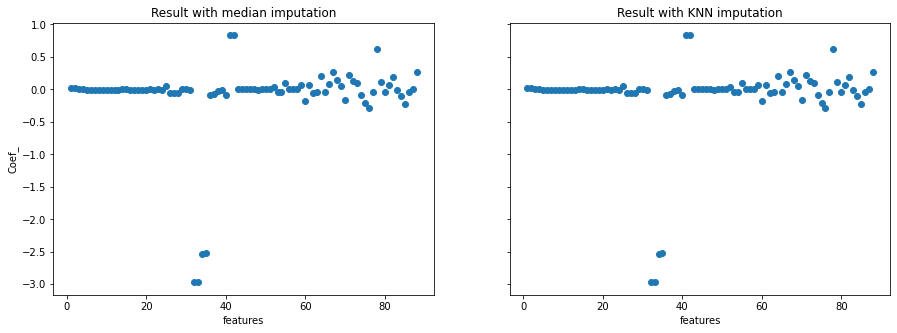

In [174]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (15,5))

#Median result
axes[0].scatter(x= range(1,89),y = LR_pipe[1].coef_)
axes[0].set_ylabel("Coef_")
axes[0].set_xlabel("features")
axes[0].set_title("Result with median imputation")

#KNN result
axes[1].scatter(x= range(1,89),y = LR_pipe[1].coef_)
axes[1].set_xlabel("features")
axes[1].set_title("Result with KNN imputation")

#Save fig
plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/Imputation_Fig.png")

## START OF REAL STUFF: prepping

In [35]:
Y_array_Class = pd.qcut(Y_array, 4, labels=["very low incidence of smoking", "low incidence of smoking", "medium incidence of smoking", "high incidence of smoking"])

In [36]:
X_train,X_test,Y_train_C,Y_test_C = train_test_split(X_array,Y_array_Class, random_state = 0)
print(X_train.shape)
print(Y_train_C.shape)
print(X_test.shape)
print(Y_test_C.shape)

(12423, 88)
(12423,)
(4142, 88)
(4142,)


In [37]:
Y_train_C

['medium incidence of smoking', 'high incidence of smoking', 'low incidence of smoking', 'medium incidence of smoking', 'high incidence of smoking', ..., 'low incidence of smoking', 'medium incidence of smoking', 'low incidence of smoking', 'high incidence of smoking', 'medium incidence of smoking']
Length: 12423
Categories (4, object): ['very low incidence of smoking' < 'low incidence of smoking' < 'medium incidence of smoking' < 'high incidence of smoking']

# actual stuff

## Visualizing

### Corelation matrix?

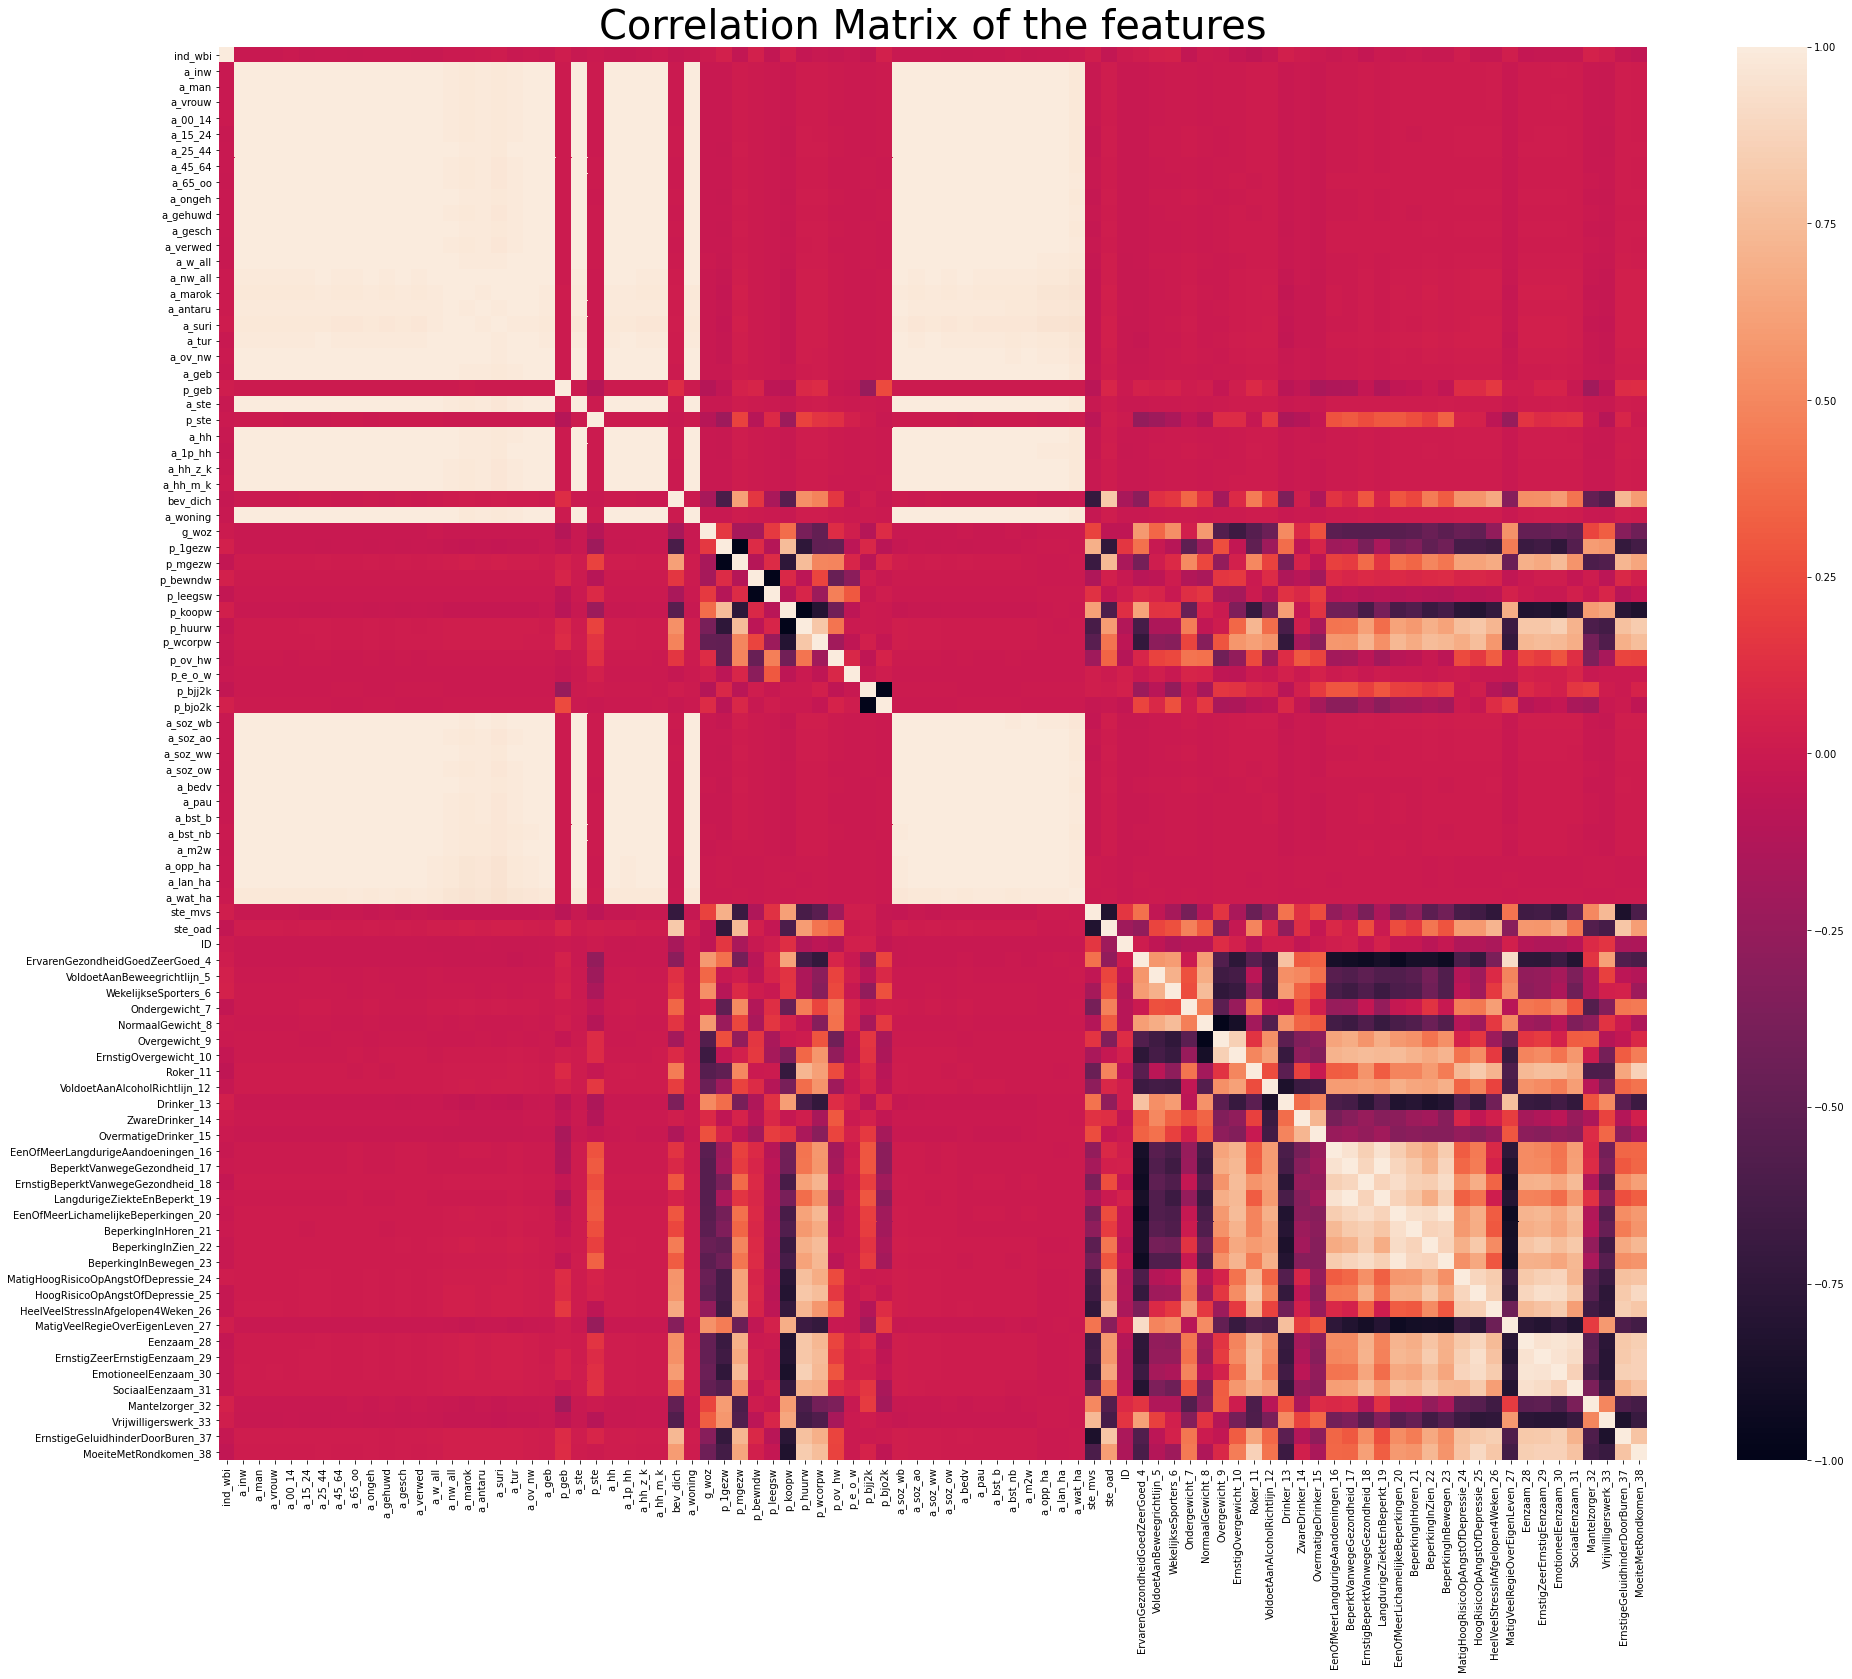

In [150]:
plt.figure(figsize = (32,26))
sns.heatmap(df_COM.corr(),vmin =-1,vmax = 1)

plt.title("Correlation Matrix of the features", fontsize =40)
plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/Corr_Fig.png")

### Feature plots

In [ ]:
#Goal: histogram with dist. of each feature (Title: feature name)
#88 features 1 target, keep target separate

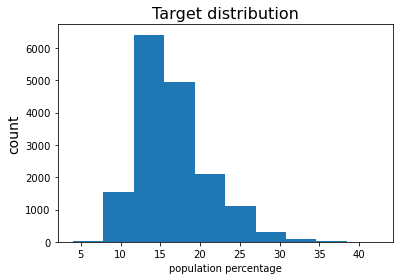

In [191]:
#Target
#plot
plt.xlabel('population percentage')
plt.ylabel("count", fontsize = 14)
plt.title("Target distribution", fontsize = 16)
plt.hist(df_COM["Roker_11"])
#Save
plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/TargetDist_Fig.png")

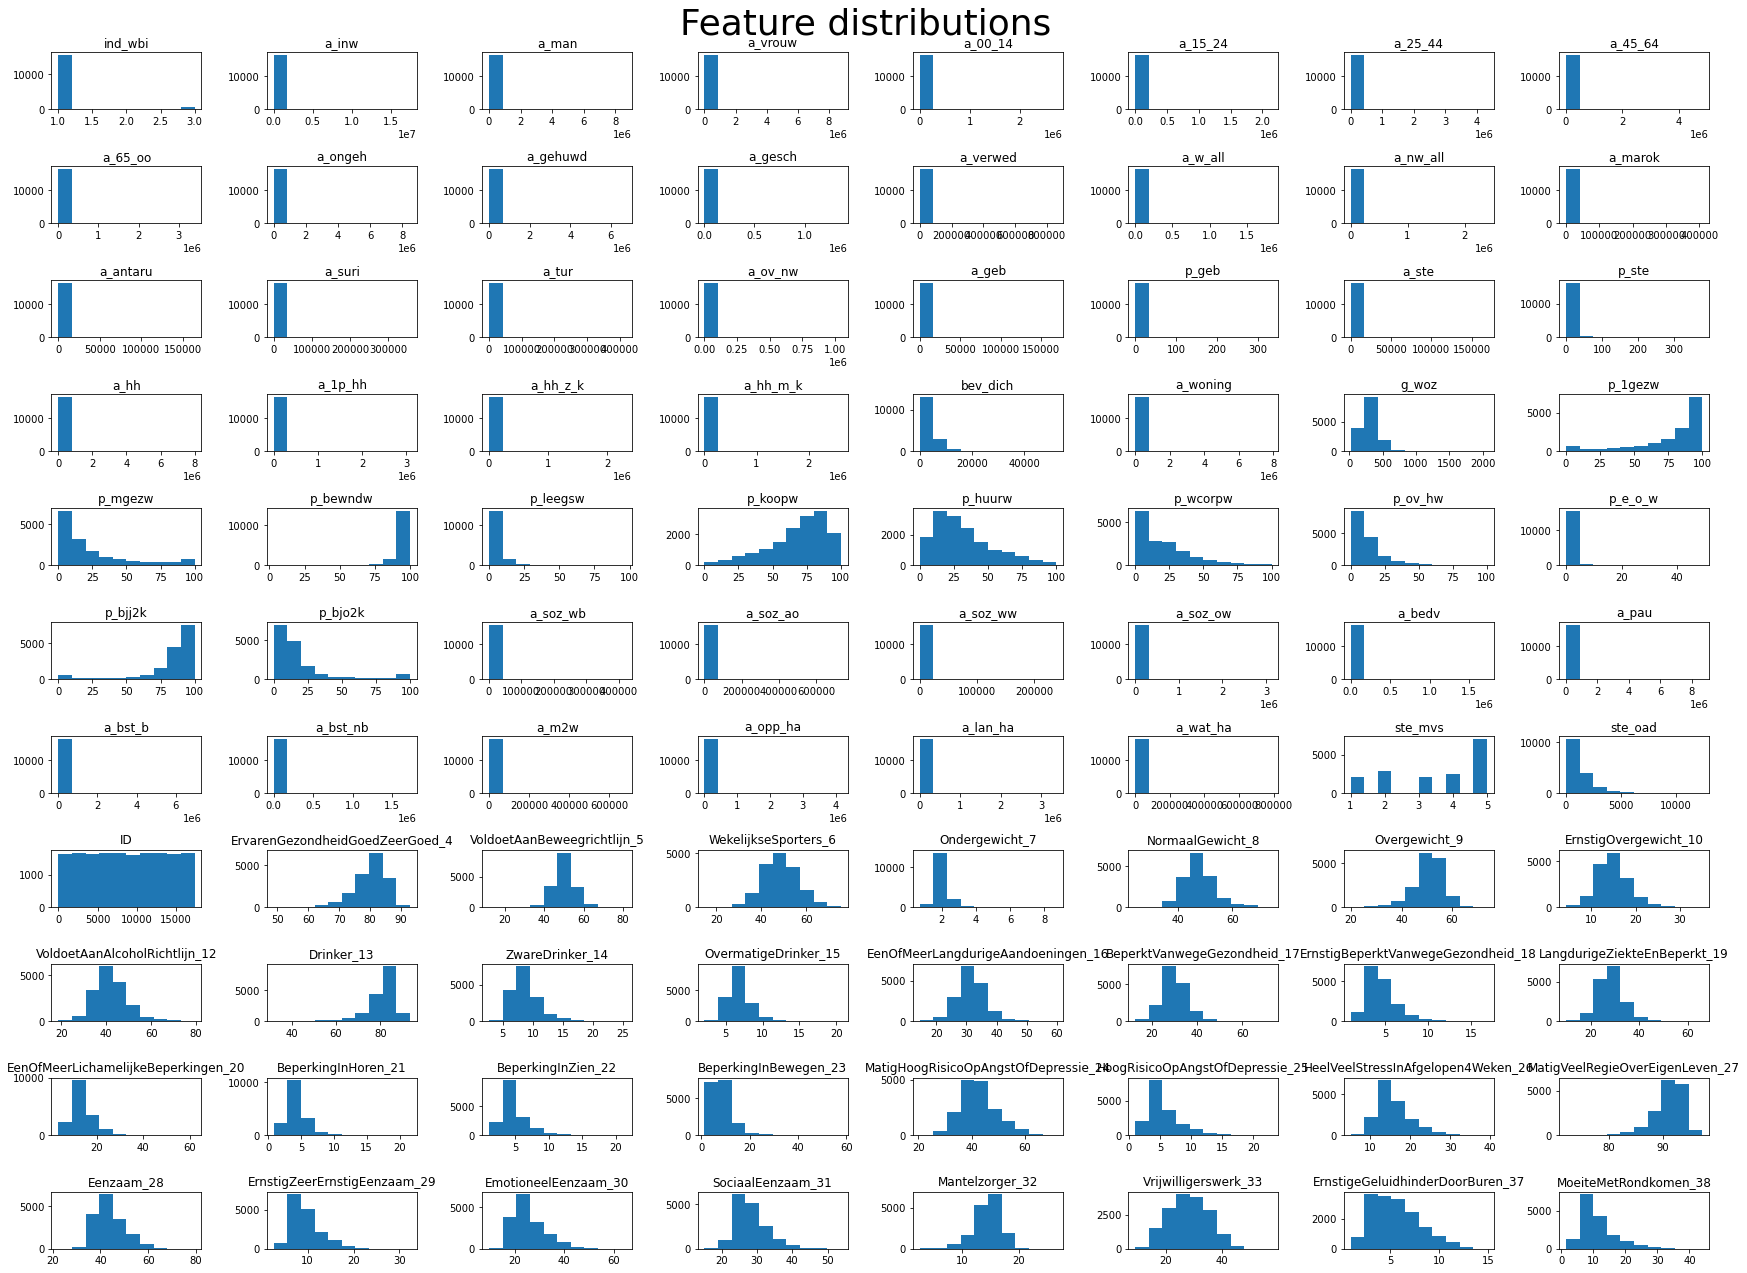

In [166]:
features = np.array(df_COM.drop(columns = 'Roker_11').columns.to_list()).reshape(11,8)
fig, axes = plt.subplots(nrows=11, ncols=8, figsize=(24, 18))
row = 0
for feats in features:
    col = 0
    for feat in feats:
        axes[row,col].hist(df_COM[feat])
        axes[row,col].set_title(feat)
        col+=1
    row+=1
fig.suptitle('Feature distributions', fontsize = 36)
fig.tight_layout()


## RandomForest

In [39]:
RF_pipe = make_pipeline(KNNImputer(n_neighbors = 5, weights = 'distance'),RandomForestClassifier(n_jobs = -1, random_state = 0))

In [40]:
RF_pipe

Pipeline(steps=[('knnimputer', KNNImputer(weights='distance')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=0))])

In [41]:
RF_pipe.fit(X_train,Y_train_C)

Pipeline(steps=[('knnimputer', KNNImputer(weights='distance')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=0))])

In [42]:
RF_pipe.score(X_test,Y_test_C)

0.7904394012554321

### Grid with RF

In [47]:
Param_grid = {'knnimputer__n_neighbors':[3,5,8],'randomforestclassifier__max_depth':[5,10,15,20],'randomforestclassifier__max_features':[5,10,20,30]}
RF_Grid = GridSearchCV(estimator = RF_pipe, param_grid = Param_grid, n_jobs = -1, cv = 5,return_train_score = True)

In [48]:
RF_Grid.fit(X_train,Y_train_C)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('knnimputer',
                                        KNNImputer(weights='distance')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'knnimputer__n_neighbors': [3, 5, 8],
                         'randomforestclassifier__max_depth': [5, 10, 15, 20,
                                                               25],
                         'randomforestclassifier__max_features': [5, 10, 20, 30,
                                                                  40]},
             return_train_score=True)

In [100]:
Temp3 = pd.DataFrame(RF_Grid.cv_results_)[(pd.DataFrame(RF_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 3)]
Temp5 = pd.DataFrame(RF_Grid.cv_results_)[(pd.DataFrame(RF_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 5)]
Temp8 = pd.DataFrame(RF_Grid.cv_results_)[(pd.DataFrame(RF_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 8)]

In [108]:
Features_Array_3 = Temp3.groupby('param_randomforestclassifier__max_features').mean().index.tolist()
Features_Array_TestScore_3 = Temp3.groupby('param_randomforestclassifier__max_features').mean()['mean_test_score']
Features_Array_TrainScore_3 = Temp3.groupby('param_randomforestclassifier__max_features').mean()['mean_train_score']

Features_Array_5 = Temp5.groupby('param_randomforestclassifier__max_features').mean().index.tolist()
Features_Array_TestScore_5 = Temp5.groupby('param_randomforestclassifier__max_features').mean()['mean_test_score']
Features_Array_TrainScore_5 = Temp5.groupby('param_randomforestclassifier__max_features').mean()['mean_train_score']

Features_Array_8 = Temp8.groupby('param_randomforestclassifier__max_features').mean().index.tolist()
Features_Array_TestScore_8 = Temp8.groupby('param_randomforestclassifier__max_features').mean()['mean_test_score']
Features_Array_TrainScore_8 = Temp8.groupby('param_randomforestclassifier__max_features').mean()['mean_train_score']

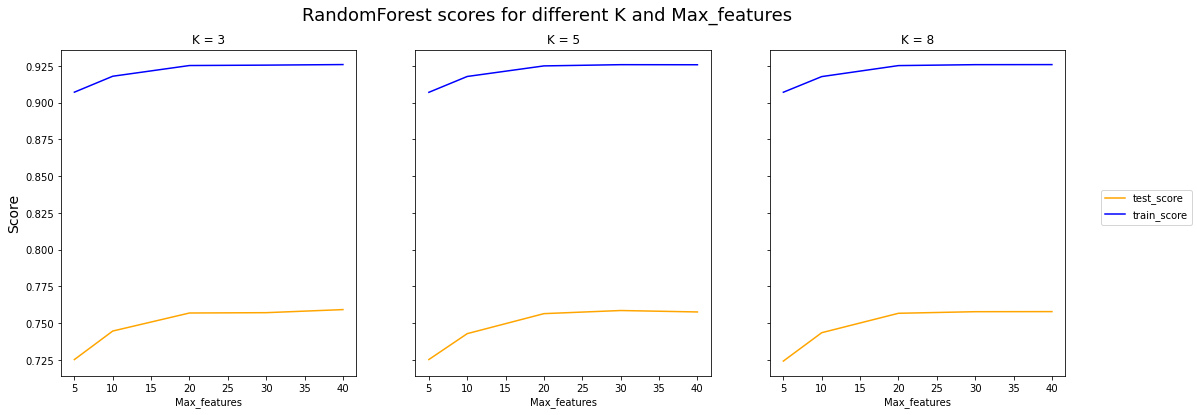

In [192]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),sharex = True,sharey = True)

#Axis labeling
axes[0].set_ylabel("Score", fontsize = 14)
axes[0].set_title("K = 3")
axes[0].set_xlabel("Max_features")
axes[1].set_title("K = 5")
axes[1].set_xlabel("Max_features")
axes[2].set_title("K = 8")
axes[2].set_xlabel("Max_features")

#PLotting
axes[0].plot(Features_Array_3,Features_Array_TestScore_3,color= 'orange')
axes[0].plot(Features_Array_3,Features_Array_TrainScore_3,color= 'blue')

axes[1].plot(Features_Array_5,Features_Array_TestScore_5,color= 'orange')
axes[1].plot(Features_Array_5,Features_Array_TrainScore_5,color= 'blue')

axes[2].plot(Features_Array_8,Features_Array_TestScore_8,color= 'orange')
axes[2].plot(Features_Array_8,Features_Array_TrainScore_8,color= 'blue')

#Figure labels
fig.suptitle('RandomForest scores for different K and Max_features', fontsize = 18)
fig.legend(['test_score','train_score'],loc = 'center right')

#saving figure
plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/RF_feature_Fig.png")

In [113]:
Depth_Array_3 = Temp3.groupby('param_randomforestclassifier__max_depth').mean().index.tolist()
Depth_Array_TestScore_3 = Temp3.groupby('param_randomforestclassifier__max_depth').mean()['mean_test_score']
Depth_Array_TrainScore_3 = Temp3.groupby('param_randomforestclassifier__max_depth').mean()['mean_train_score']

Depth_Array_5 = Temp5.groupby('param_randomforestclassifier__max_depth').mean().index.tolist()
Depth_Array_TestScore_5 = Temp5.groupby('param_randomforestclassifier__max_depth').mean()['mean_test_score']
Depth_Array_TrainScore_5 = Temp5.groupby('param_randomforestclassifier__max_depth').mean()['mean_train_score']

Depth_Array_8 = Temp8.groupby('param_randomforestclassifier__max_depth').mean().index.tolist()
Depth_Array_TestScore_8 = Temp8.groupby('param_randomforestclassifier__max_depth').mean()['mean_test_score']
Depth_Array_TrainScore_8 = Temp8.groupby('param_randomforestclassifier__max_depth').mean()['mean_train_score']

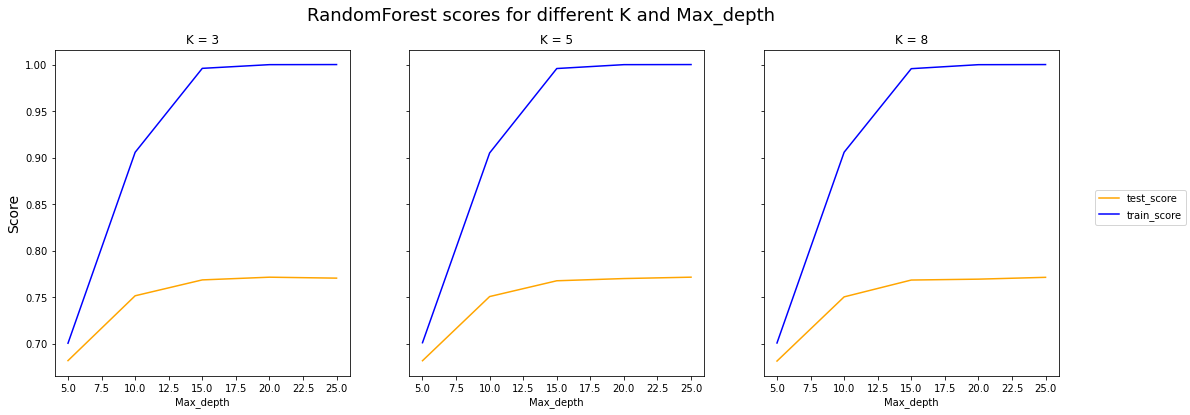

In [193]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),sharex = True,sharey = True)

#Axis labeling
axes[0].set_ylabel("Score", fontsize = 14)
axes[0].set_title("K = 3")
axes[0].set_xlabel("Max_depth")
axes[1].set_title("K = 5")
axes[1].set_xlabel("Max_depth")
axes[2].set_title("K = 8")
axes[2].set_xlabel("Max_depth")

#PLotting
axes[0].plot(Depth_Array_3,Depth_Array_TestScore_3,color= 'orange')
axes[0].plot(Depth_Array_3,Depth_Array_TrainScore_3,color= 'blue')

axes[1].plot(Depth_Array_5,Depth_Array_TestScore_5,color= 'orange')
axes[1].plot(Depth_Array_5,Depth_Array_TrainScore_5,color= 'blue')

axes[2].plot(Depth_Array_8,Depth_Array_TestScore_8,color= 'orange')
axes[2].plot(Depth_Array_8,Depth_Array_TrainScore_8,color= 'blue')

#Figure labels
fig.suptitle('RandomForest scores for different K and Max_depth', fontsize = 18)
fig.legend(['test_score','train_score'],loc = 'center right')

#saving figure
plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/RF_depth_Fig.png")

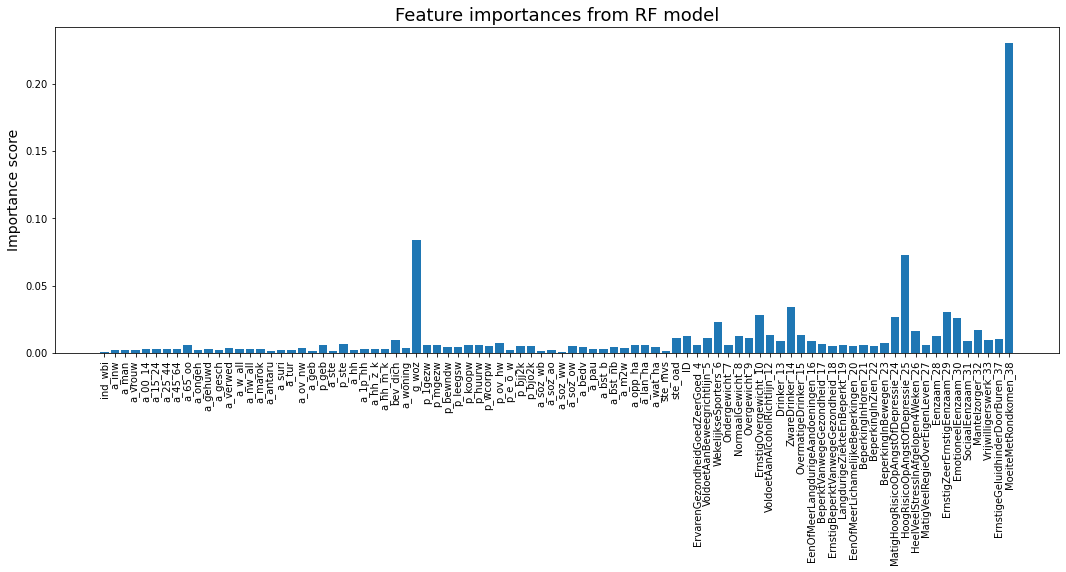

In [194]:
#grabbing labels
Labels = df_COM.drop(columns = ['Roker_11']).columns.to_list()

#setting up plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

#labeling axes
axes.set_title("Feature importances from RF model", fontsize = 18)
axes.set_ylabel("Importance score", fontsize = 14)
plt.xticks(ticks = range(0,len(Labels)),labels = Labels,rotation = "vertical")

#Plotting bar chart
axes.bar(range(0, len(RF_Grid.best_estimator_[-1].feature_importances_)),RF_Grid.best_estimator_[-1].feature_importances_)

#Saving fig
plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/RF_importance_Fig.png")

## SVC

In [60]:

SVC_pipe = make_pipeline(KNNImputer(n_neighbors = 5, weights = 'distance'),StandardScaler(),SVC(random_state = 0))

In [61]:
SVC_pipe.fit(X_train,Y_train_C)

Pipeline(steps=[('knnimputer', KNNImputer(weights='distance')),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [62]:
SVC_pipe.score(X_test,Y_test_C)

0.7870593915982617

### SVC grid

In [63]:
Param_grid = {'knnimputer__n_neighbors':[3,5,8],'svc__C':np.logspace(-2,5,9),'svc__gamma':['scale','auto']}
SVC_Grid = GridSearchCV(estimator = SVC_pipe, param_grid = Param_grid, n_jobs = -1, cv = 5,return_train_score = True)

In [64]:
SVC_Grid.fit(X_train,Y_train_C)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('knnimputer',
                                        KNNImputer(weights='distance')),
                                       ('standardscaler', StandardScaler()),
                                       ('svc', SVC(random_state=0))]),
             n_jobs=-1,
             param_grid={'knnimputer__n_neighbors': [3, 5, 8],
                         'svc__C': array([1.00000000e-02, 3.98107171e-02, 1.58489319e-01, 6.30957344e-01,
       2.51188643e+00, 1.00000000e+01, 3.98107171e+01, 1.58489319e+02,
       6.30957344e+02, 2.51188643e+03, 1.00000000e+04]),
                         'svc__gamma': ['scale', 'auto']},
             return_train_score=True)

In [66]:
S_3 = pd.DataFrame(SVC_Grid.cv_results_)[(pd.DataFrame(SVC_Grid.cv_results_)['param_svc__gamma'] == 'scale') & (pd.DataFrame(SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 3)]
A_3 = pd.DataFrame(SVC_Grid.cv_results_)[(pd.DataFrame(SVC_Grid.cv_results_)['param_svc__gamma'] == 'auto') & (pd.DataFrame(SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 3)]

S_5 = pd.DataFrame(SVC_Grid.cv_results_)[(pd.DataFrame(SVC_Grid.cv_results_)['param_svc__gamma'] == 'scale') & (pd.DataFrame(SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 5)]
A_5 = pd.DataFrame(SVC_Grid.cv_results_)[(pd.DataFrame(SVC_Grid.cv_results_)['param_svc__gamma'] == 'auto') & (pd.DataFrame(SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 5)]

S_8 = pd.DataFrame(SVC_Grid.cv_results_)[(pd.DataFrame(SVC_Grid.cv_results_)['param_svc__gamma'] == 'scale') & (pd.DataFrame(SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 8)]
A_8 = pd.DataFrame(SVC_Grid.cv_results_)[(pd.DataFrame(SVC_Grid.cv_results_)['param_svc__gamma'] == 'auto') & (pd.DataFrame(SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 8)]


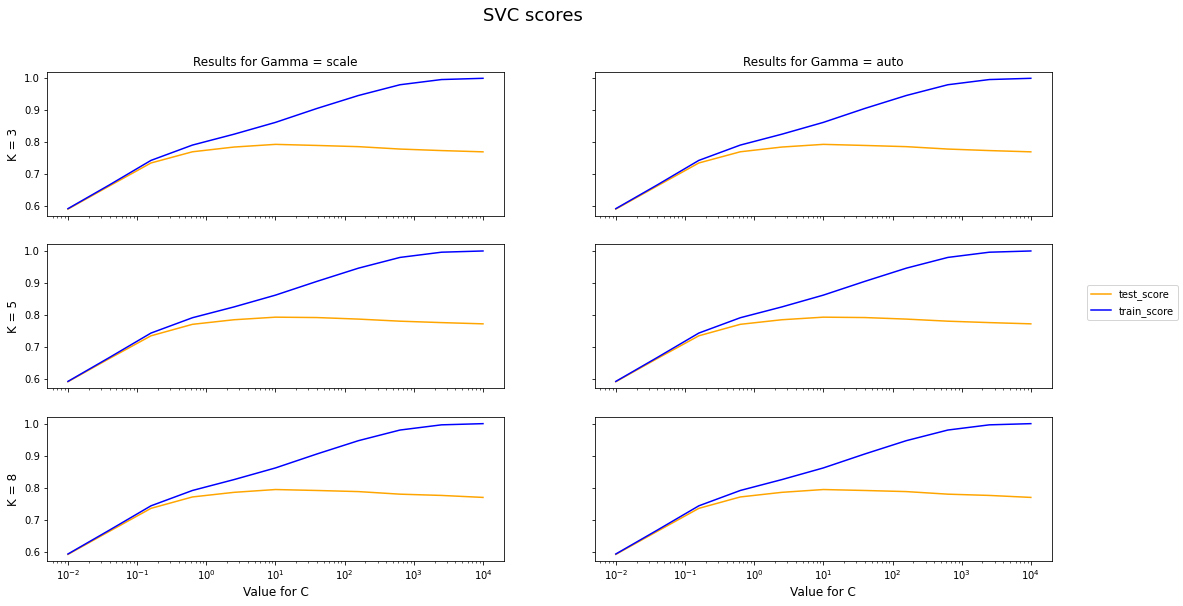

In [99]:
#K=3
S_3_C = S_3['param_svc__C']
S_3_Test = S_3['mean_test_score']
S_3_Train = S_3['mean_train_score']
A_3_C = A_3['param_svc__C']
A_3_Test = A_3['mean_test_score']
A_3_Train = A_3['mean_train_score']
#K=3
S_5_C = S_5['param_svc__C']
S_5_Test = S_5['mean_test_score']
S_5_Train = S_5['mean_train_score']
A_5_C = A_5['param_svc__C']
A_5_Test = A_5['mean_test_score']
A_5_Train = A_5['mean_train_score']
#K=3
S_8_C = S_8['param_svc__C']
S_8_Test = S_8['mean_test_score']
S_8_Train = S_8['mean_train_score']
A_8_C = A_8['param_svc__C']
A_8_Test = A_8['mean_test_score']
A_8_Train = A_8['mean_train_score']

#Make subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 9),sharex = True,sharey = True)
plt.xscale("log")

#Set labes
axes[0,0].set_title('Results for Gamma = scale')
axes[0,1].set_title('Results for Gamma = auto')
axes[2,0].set_xlabel('Value for C', fontsize = 12)
axes[2,1].set_xlabel('Value for C', fontsize = 12)
axes[0,0].set_ylabel('K = 3', fontsize = 12)
axes[1,0].set_ylabel('K = 5', fontsize = 12)
axes[2,0].set_ylabel('K = 8', fontsize = 12)

#Fill plots
#K = 3
axes[0,0].plot(S_3_C,S_3_Test, color  = "orange")
axes[0,0].plot(S_3_C,S_3_Train, color  = "blue")
axes[0,1].plot(A_3_C,A_3_Test, color  = "orange")
axes[0,1].plot(A_3_C,A_3_Train, color  = "blue")
#K = 5
axes[1,0].plot(S_5_C,S_5_Test, color  = "orange")
axes[1,0].plot(S_5_C,S_5_Train, color  = "blue")
axes[1,1].plot(A_5_C,A_5_Test, color  = "orange")
axes[1,1].plot(A_5_C,A_5_Train, color  = "blue")
#K = 8
axes[2,0].plot(S_8_C,S_8_Test, color  = "orange")
axes[2,0].plot(S_8_C,S_8_Train, color  = "blue")
axes[2,1].plot(A_8_C,A_8_Test, color  = "orange")
axes[2,1].plot(A_8_C,A_8_Train, color  = "blue")

fig.suptitle('SVC scores', fontsize = 18)
fig.legend(['test_score','train_score'],loc = 'center right')

plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/SVC_Fig.png")

In [181]:
SVC_F_importance = permutation_importance(SVC_Grid.best_estimator_,X_test,Y_test_C, n_jobs = -1,n_repeats = 3, random_state = 0)

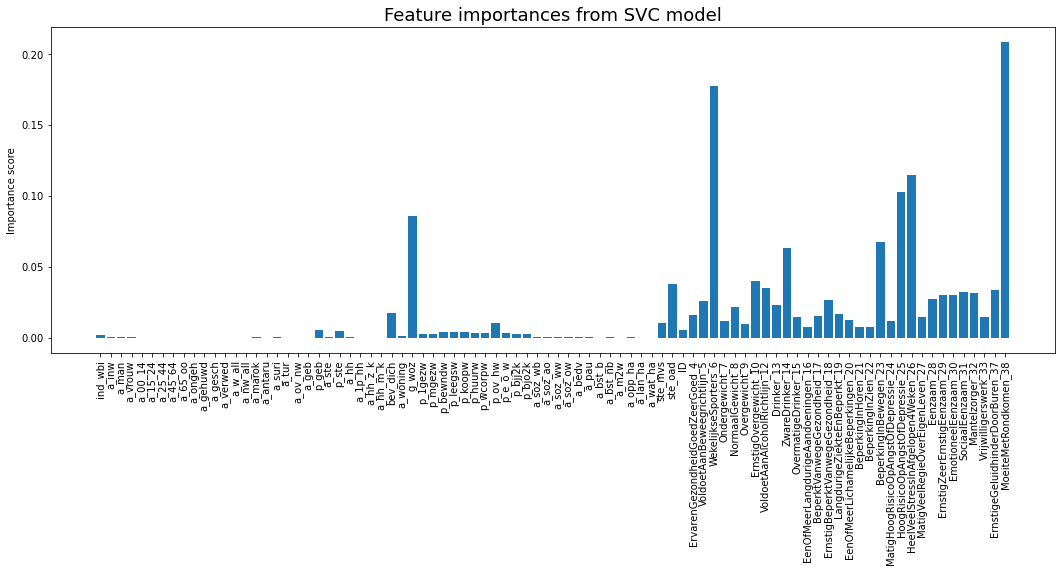

In [183]:
#grabbing labels
Labels = df_COM.drop(columns = ['Roker_11']).columns.to_list()

#setting up plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

#labeling axes
axes.set_title("Feature importances from SVC model", fontsize = 18)
axes.set_ylabel("Importance score")
plt.xticks(ticks = range(0,len(Labels)),labels = Labels,rotation = "vertical")

#Plotting bar chart
axes.bar(range(0, len(SVC_F_importance.importances_mean)),SVC_F_importance.importances_mean)

#Saving fig
plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/SVC_importance_Fig.png")

## LinearSVC

In [72]:
from sklearn.svm import LinearSVC

In [73]:
L_SVC_pipe = make_pipeline(KNNImputer(n_neighbors = 5, weights = 'distance'),StandardScaler(),LinearSVC(dual = False,random_state = 0))

In [74]:
L_SVC_pipe.fit(X_train,Y_train_C)

Pipeline(steps=[('knnimputer', KNNImputer(weights='distance')),
                ('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=False, random_state=0))])

In [75]:
L_SVC_pipe.score(X_test,Y_test_C)

0.7218734910671173

### LinearSVC grid

In [76]:
Param_grid = {'knnimputer__n_neighbors':[3,5,8],'linearsvc__C':np.logspace(-3,5,11),'linearsvc__penalty':['l1','l2']}
L_SVC_Grid = GridSearchCV(estimator = L_SVC_pipe, param_grid = Param_grid, n_jobs = -1, cv = 5,return_train_score = True)

In [77]:
L_SVC_Grid.fit(X_train,Y_train_C)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('knnimputer',
                                        KNNImputer(weights='distance')),
                                       ('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(dual=False,
                                                  random_state=0))]),
             n_jobs=-1,
             param_grid={'knnimputer__n_neighbors': [3, 5, 8],
                         'linearsvc__C': array([1.00000000e-03, 6.30957344e-03, 3.98107171e-02, 2.51188643e-01,
       1.58489319e+00, 1.00000000e+01, 6.30957344e+01, 3.98107171e+02,
       2.51188643e+03, 1.58489319e+04, 1.00000000e+05]),
                         'linearsvc__penalty': ['l1', 'l2']},
             return_train_score=True)

In [81]:
LS_1_3 = pd.DataFrame(L_SVC_Grid.cv_results_)[(pd.DataFrame(L_SVC_Grid.cv_results_)['param_linearsvc__penalty'] == 'l1') & (pd.DataFrame(L_SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 3)]
LS_2_3 = pd.DataFrame(L_SVC_Grid.cv_results_)[(pd.DataFrame(L_SVC_Grid.cv_results_)['param_linearsvc__penalty'] == 'l2') & (pd.DataFrame(L_SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 3)]

LS_1_5 = pd.DataFrame(L_SVC_Grid.cv_results_)[(pd.DataFrame(L_SVC_Grid.cv_results_)['param_linearsvc__penalty'] == 'l1') & (pd.DataFrame(L_SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 5)]
LS_2_5 = pd.DataFrame(L_SVC_Grid.cv_results_)[(pd.DataFrame(L_SVC_Grid.cv_results_)['param_linearsvc__penalty'] == 'l2') & (pd.DataFrame(L_SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 5)]

LS_1_8 = pd.DataFrame(L_SVC_Grid.cv_results_)[(pd.DataFrame(L_SVC_Grid.cv_results_)['param_linearsvc__penalty'] == 'l1') & (pd.DataFrame(L_SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 8)]
LS_2_8 = pd.DataFrame(L_SVC_Grid.cv_results_)[(pd.DataFrame(L_SVC_Grid.cv_results_)['param_linearsvc__penalty'] == 'l2') & (pd.DataFrame(L_SVC_Grid.cv_results_)['param_knnimputer__n_neighbors'] == 8)]

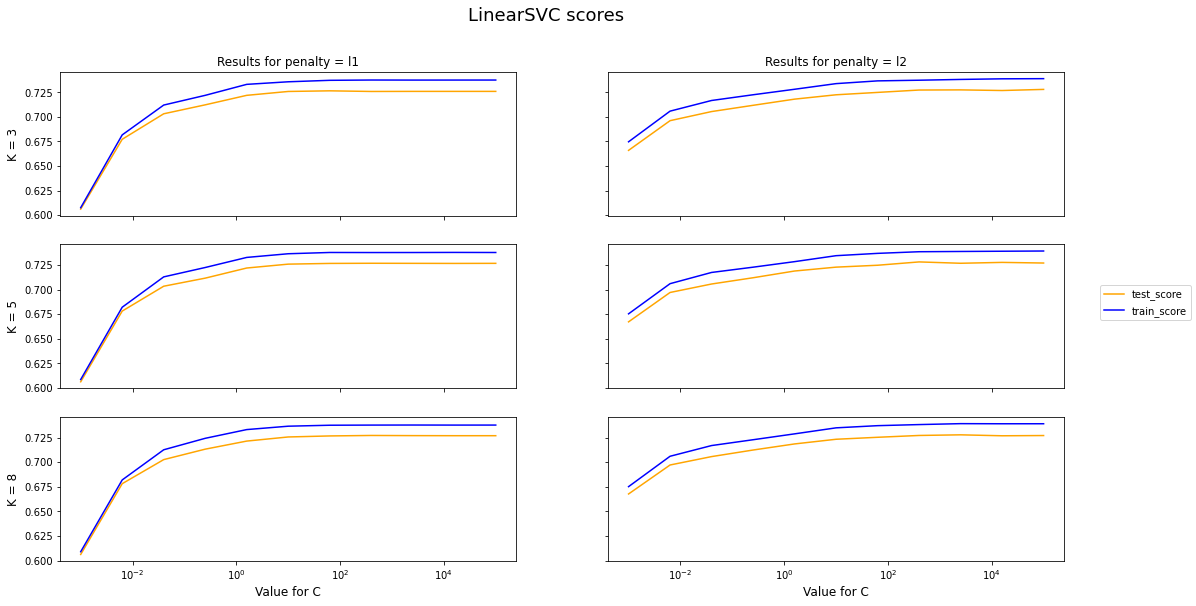

In [96]:
#L1 for K=3
L1_3_Array = LS_1_3['param_linearsvc__C']
L1_3_Array_Test = LS_1_3['mean_test_score']
L1_3_Array_Train = LS_1_3['mean_train_score']
#L2 for K=3
L2_3_Array = LS_2_3['param_linearsvc__C']
L2_3_Array_Test = LS_2_3['mean_test_score']
L2_3_Array_Train = LS_2_3['mean_train_score']

#L1 for K=5
L1_5_Array = LS_1_5['param_linearsvc__C']
L1_5_Array_Test = LS_1_5['mean_test_score']
L1_5_Array_Train = LS_1_5['mean_train_score']
#L2 for K=5
L2_5_Array = LS_2_5['param_linearsvc__C']
L2_5_Array_Test = LS_2_5['mean_test_score']
L2_5_Array_Train = LS_2_5['mean_train_score']

#L1 for K=8
L1_8_Array = LS_1_8['param_linearsvc__C']
L1_8_Array_Test = LS_1_8['mean_test_score']
L1_8_Array_Train = LS_1_8['mean_train_score']
#L2 for K= 8
L2_8_Array = LS_2_8['param_linearsvc__C']
L2_8_Array_Test = LS_2_8['mean_test_score']
L2_8_Array_Train = LS_2_8['mean_train_score']

#Make subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 9),sharex = True,sharey = True)
plt.xscale("log")

#Set labes
axes[0,0].set_title('Results for penalty = l1')
axes[0,1].set_title('Results for penalty = l2')
axes[2,0].set_xlabel('Value for C', fontsize = 12)
axes[2,1].set_xlabel('Value for C', fontsize = 12)
axes[0,0].set_ylabel('K = 3', fontsize = 12)
axes[1,0].set_ylabel('K = 5', fontsize = 12)
axes[2,0].set_ylabel('K = 8', fontsize = 12)

#Fill plots
#K = 3
axes[0,0].plot(L1_3_Array,L1_3_Array_Test, color  = "orange")
axes[0,0].plot(L1_3_Array,L1_3_Array_Train, color  = "blue")
axes[0,1].plot(L2_3_Array,L2_3_Array_Test, color  = "orange")
axes[0,1].plot(L2_3_Array,L2_3_Array_Train, color  = "blue")
#K = 5
axes[1,0].plot(L1_5_Array,L1_5_Array_Test, color  = "orange")
axes[1,0].plot(L1_5_Array,L1_5_Array_Train, color  = "blue")
axes[1,1].plot(L2_5_Array,L2_5_Array_Test, color  = "orange")
axes[1,1].plot(L2_5_Array,L2_5_Array_Train, color  = "blue")
#K = 8
axes[2,0].plot(L1_8_Array,L1_8_Array_Test, color  = "orange")
axes[2,0].plot(L1_8_Array,L1_8_Array_Train, color  = "blue")
axes[2,1].plot(L2_8_Array,L2_8_Array_Test, color  = "orange")
axes[2,1].plot(L2_8_Array,L2_8_Array_Train, color  = "blue")

fig.suptitle('LinearSVC scores', fontsize = 18)
fig.legend(['test_score','train_score'],loc = 'center right')

plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/L_SVC_Fig.png")


In [186]:
#Getting feature importances for LinearSVC
L_SVC_F_importance = permutation_importance(L_SVC_Grid.best_estimator_,X_test,Y_test_C, n_jobs = -1,n_repeats = 3, random_state = 0)

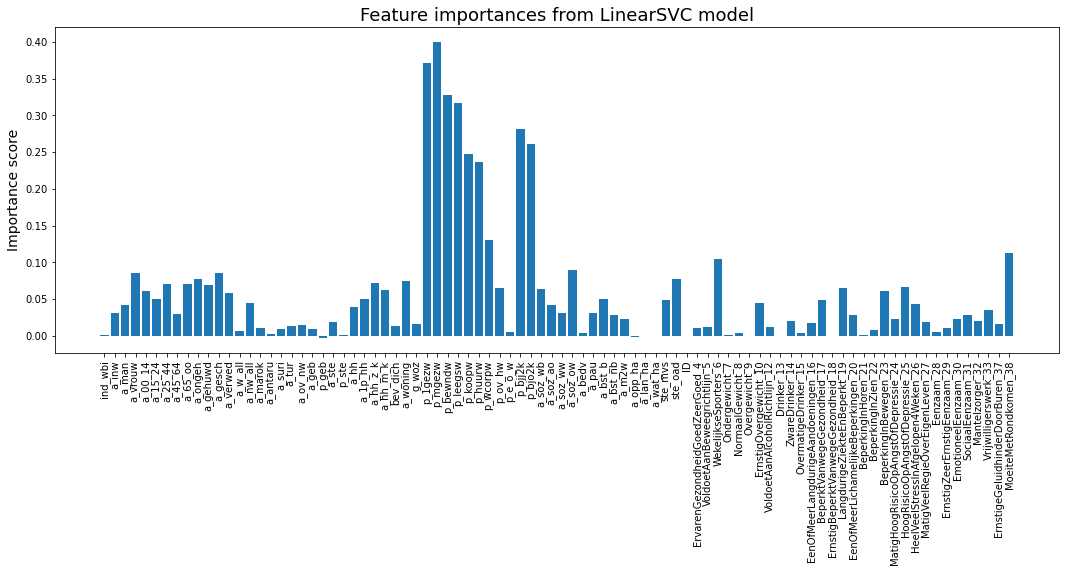

In [190]:
#grabbing labels 
Labels = df_COM.drop(columns = ['Roker_11']).columns.to_list()


#setting up plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

#labeling axes
axes.set_title("Feature importances from LinearSVC model", fontsize = 18)
axes.set_ylabel("Importance score", fontsize = 14)
plt.xticks(ticks = range(0,len(Labels)),labels = Labels,rotation = "vertical")

#Plotting bar chart
axes.bar(range(0, len(L_SVC_F_importance.importances_mean)),L_SVC_F_importance.importances_mean)

#Saving fig
plt.savefig("C:/Users/Kevin/Desktop/Per_2_Minor/ML/Project/Project/Figures/L_SVC_importance_Fig.png")

# KNN

In [87]:
# KNeighborsClassifier_raw = make_pipeline(KNNImputer(n_neighbors = 5, weights = 'distance'),KNeighborsClassifier())
# KNeighborsClassifier_pipe_stdscaled= make_pipeline(KNNImputer(n_neighbors = 5, weights = 'distance'),StandardScaler(),KNeighborsClassifier())

In [88]:
# KNeighborsClassifier_raw.fit(X_train, Y_train_C)

In [89]:
# KNeighborsClassifier_raw.score(X_test, Y_test_C)

In [90]:
# param_grid_knn_stdscaled = {'kneighborsclassifier__n_neighbors': range(1, 15)}
# grid_knn_stdscaled = GridSearchCV(KNeighborsClassifier_pipe_stdscaled, param_grid_knn_stdscaled, cv=10, n_jobs = 7)
# grid_knn_stdscaled.fit(X_train, Y_train_C)
# print(grid_knn_stdscaled.best_params_)
# print(grid_knn_stdscaled.score(X_test, Y_test_C))

In [91]:
# Y_pred_KNN = grid_knn_stdscaled.predict(X_test)
# print(f'Classification Report KNN stdscaled: \n{classification_report(Y_test_C,Y_pred_SVC)}')

## Classification reports and model parameters

### RF

In [92]:
print(RF_Grid.best_estimator_,"\n\n")
print(RF_Grid.best_params_,"\n\n")
print(f"accuracy of best model:{RF_Grid.best_score_}\n\n")
Y_pred_randomforest = RF_Grid.predict(X_test)
print(f'Classification Report Random Forest: \n{classification_report(Y_test_C,Y_pred_randomforest)}')

Pipeline(steps=[('knnimputer', KNNImputer(n_neighbors=3, weights='distance')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, max_features=40,
                                        n_jobs=-1, random_state=0))]) 


{'knnimputer__n_neighbors': 3, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 40} 


accuracy of best model:0.7790395837180896


Classification Report Random Forest: 
                               precision    recall  f1-score   support

    high incidence of smoking       0.91      0.89      0.90       968
     low incidence of smoking       0.67      0.69      0.68       991
  medium incidence of smoking       0.75      0.74      0.74      1051
very low incidence of smoking       0.85      0.85      0.85      1132

                     accuracy                           0.79      4142
                    macro avg       0.79      0.79      0.79      4142
                 weighted avg     

### SVC

In [93]:
print(SVC_Grid.best_estimator_,"\n\n")
print(SVC_Grid.best_params_,"\n\n")
print(f"accuracy of best model:{SVC_Grid.best_score_}\n\n")
Y_pred_SVC = SVC_Grid.predict(X_test)
print(f'Classification Report SVC: \n{classification_report(Y_test_C,Y_pred_SVC)}')

Pipeline(steps=[('knnimputer', KNNImputer(n_neighbors=8, weights='distance')),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(C=10.0, random_state=0))]) 


{'knnimputer__n_neighbors': 8, 'svc__C': 10.0, 'svc__gamma': 'scale'} 


accuracy of best model:0.7936902898874729


Classification Report SVC: 
                               precision    recall  f1-score   support

    high incidence of smoking       0.92      0.91      0.92       968
     low incidence of smoking       0.67      0.71      0.69       991
  medium incidence of smoking       0.78      0.76      0.77      1051
very low incidence of smoking       0.85      0.85      0.85      1132

                     accuracy                           0.81      4142
                    macro avg       0.81      0.81      0.81      4142
                 weighted avg       0.81      0.81      0.81      4142



### LinearSVC

In [94]:
print(L_SVC_Grid.best_estimator_,"\n\n")
print(L_SVC_Grid.best_params_,"\n\n")
print(f"accuracy of best model:{L_SVC_Grid.best_score_}\n\n")
Y_pred_L_SVC = L_SVC_Grid.predict(X_test)
print(f'Classification Report SVC: \n{classification_report(Y_test_C,Y_pred_L_SVC)}')

Pipeline(steps=[('knnimputer', KNNImputer(weights='distance')),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=398.1071705534977, dual=False, random_state=0))]) 


{'knnimputer__n_neighbors': 5, 'linearsvc__C': 398.1071705534977, 'linearsvc__penalty': 'l2'} 


accuracy of best model:0.7280861983495173


Classification Report SVC: 
                               precision    recall  f1-score   support

    high incidence of smoking       0.83      0.92      0.88       968
     low incidence of smoking       0.59      0.48      0.53       991
  medium incidence of smoking       0.68      0.59      0.63      1051
very low incidence of smoking       0.76      0.91      0.83      1132

                     accuracy                           0.73      4142
                    macro avg       0.72      0.72      0.72      4142
                 weighted avg       0.72      0.73      0.72      4142

